# Notebook to plot freezing point and ice concentration of idealized simulation.

Import and start dask client. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import colorcet as cc
import xrft
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

<Client: 'tcp://127.0.0.1:34077' processes=8 threads=8, memory=32.00 GiB>

Load the data using the Import_Expt_Front, that allows to open all the experiments within a folder ath the same time.

### Important!  
the folder names within the folder path of the experiments must contain the name "expt_XXX". 

i.e.
`
expt_000 expt_001 expt_002 expt_front_0
`

In [4]:
from utils import *

In [5]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_formation_4.2.0_output/'
EXF = Import_Expt_Front(folder)

Define the experiments to ignore in the list `exp_filter`, in this case, ignore the experiments with no ice velocities.

In [6]:
exp_filter = ['expt_front_1_noICEvel','expt_front_05_noICEvel']

Slice data on time to contain from the 2nd of July until the 31st of December of the second year of the simulation

In [7]:
t0 = '0002-07-02'
tf = '0002-12-31'

In [8]:
# Ignore timesteps in case of overlap between restarts of simulations. 
def Overlap_Clear(ds):
    filename = (ds.encoding['source'])
    if "00020630-00020708" in filename:
        data = ds.isel(time_counter=slice(0,-4)).set_coords(('nav_lat', 'nav_lon'))
    else:
        data = ds.set_coords(('nav_lat', 'nav_lon'))
    return data


In [9]:
dataset_gridT_3h = EXF.import_multipe_expt('grid_T',vars_of_interest=['soce','toce'],
                                           expt_filter=exp_filter,freq='3h', preprocess=Overlap_Clear,
                                           chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [10]:
dataset_icemod_3h = EXF.import_multipe_expt('icemod',vars_of_interest=['icevolu','sithic'],
                                            expt_filter=exp_filter,freq='3h', preprocess=Overlap_Clear,
                                            chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

Load the experiments: Weak front without ice velocities and Strong front without ice velocities. 

In [11]:
scratch = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_formation_4.2.0_output/"
dataset_icemod_noIVEL_3h = xr.open_mfdataset(folder+"expt_front_1_noICEvel/*icemod_3h*",chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))
dataset_gridT_noIVEL_3h = xr.open_mfdataset(folder+"expt_front_1_noICEvel/*grid_T_3h*",chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))

dataset_icemod_noIVEL_05_3h = xr.open_mfdataset(scratch+"expt_front_05_noICEvel/*icemod_3h*",chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))
dataset_gridT_noIVEL_05_3h = xr.open_mfdataset(scratch+"expt_front_05_noICEvel/*grid_T_3h*",chunks={'time_counter':5}).sel(time_counter=slice(t0,tf))

Select area of interest.

In [12]:
y0=1
y1=250
x0=1
x1=500

times = np.array([608,648,688,828])
shifted_times = times+2

area_of_interest = {'time_counter':times,'y':slice(y0,y1),'x':slice(x0,x1)}
grid_of_interest = {'time_counter':slice(times[0]-100,times[-1]+100),'y':slice(y0,y1),'x':slice(x0,x1)}

Slice data to the respective areas of interest:

In [13]:
gridT_sel = dataset_gridT_3h.isel(area_of_interest).isel(deptht=0)
icemod_sel = dataset_icemod_3h.isel(area_of_interest)

In [14]:
time_series_gridT = dataset_gridT_3h.isel(grid_of_interest).isel(deptht=0)
time_series_icemod = dataset_icemod_3h.isel(grid_of_interest)

Compute freezing point temperature of time series.

In [15]:
# Compute the freezing point temperature
time_series_freezing_t = gsw.t_freezing( time_series_gridT, 0, 1)

In [16]:
time_series_gridT_noIVEL = dataset_gridT_noIVEL_3h.isel(grid_of_interest).isel(deptht=0)

In [17]:
time_series_freezing_t_noIVEL = gsw.t_freezing( time_series_gridT_noIVEL.soce, 0, 1)

In [18]:
time_series_gridT_05_noIVEL = dataset_gridT_noIVEL_05_3h.isel(grid_of_interest).isel(deptht=0)

In [19]:
time_series_freezing_t_05_noIVEL = gsw.t_freezing( time_series_gridT_05_noIVEL.soce, 0, 1)

Compute the freezing point temperature of surface fields

In [20]:
# Compute the freezing point temperature
freezing_t = gsw.t_freezing(gridT_sel, 0, 1)

In [21]:
# Compute the freezing point temperature
freezing_t = gsw.t_freezing( dataset_gridT_3h.isel(area_of_interest).isel(deptht=0), 0, 1)

In [22]:
time=freezing_t.isel(time_counter=slice(0,None,2)).time_counter

## Compute standard deviations of the temperature - freezing point temperature ($T-T_f$) for the time-series

In [23]:
STD_temp_anomaly_0 = (time_series_gridT.toce_front_0 - time_series_freezing_t.soce_front_0).std(("x","y")).compute()
STD_temp_anomaly_05 = (time_series_gridT.toce_front_05_noTf - time_series_freezing_t.soce_front_05_noTf).std(("x","y")).compute()
STD_temp_anomaly_1 = (time_series_gridT.toce_front_1_noTf - time_series_freezing_t.soce_front_1_noTf).std(("x","y")).compute()

In [24]:
STD_temp_anomaly_1_nIVEL = (time_series_gridT_noIVEL.toce - time_series_freezing_t_noIVEL).std(("x","y")).compute()

In [25]:
STD_temp_anomaly_05_nIVEL = (time_series_gridT_05_noIVEL.toce - time_series_freezing_t_05_noIVEL).std(("x","y")).compute()

## Compute standard deviations of ice volume. 

In [27]:
STD_icevolu_0 = time_series_icemod.icevolu_front_0.std(("x","y")).compute()
STD_icevolu_05 = time_series_icemod.icevolu_front_05_noTf.std(("x","y")).compute()
STD_icevolu_1 = time_series_icemod.icevolu_front_1_noTf.std(("x","y")).compute()

In [28]:
STD_icevolu_1_noIVEL = dataset_icemod_noIVEL_3h.icevolu.isel(grid_of_interest).std(("x","y")).compute()

In [29]:
STD_icevolu_05_noIVEL = dataset_icemod_noIVEL_05_3h.icevolu.isel(grid_of_interest).std(("x","y")).compute()

## Plot the temperature - freezing point temperature ($T-T_f$) and time-series of their standard deviation.

/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xlabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:405: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(ylabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xlabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:405: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(ylabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_tic

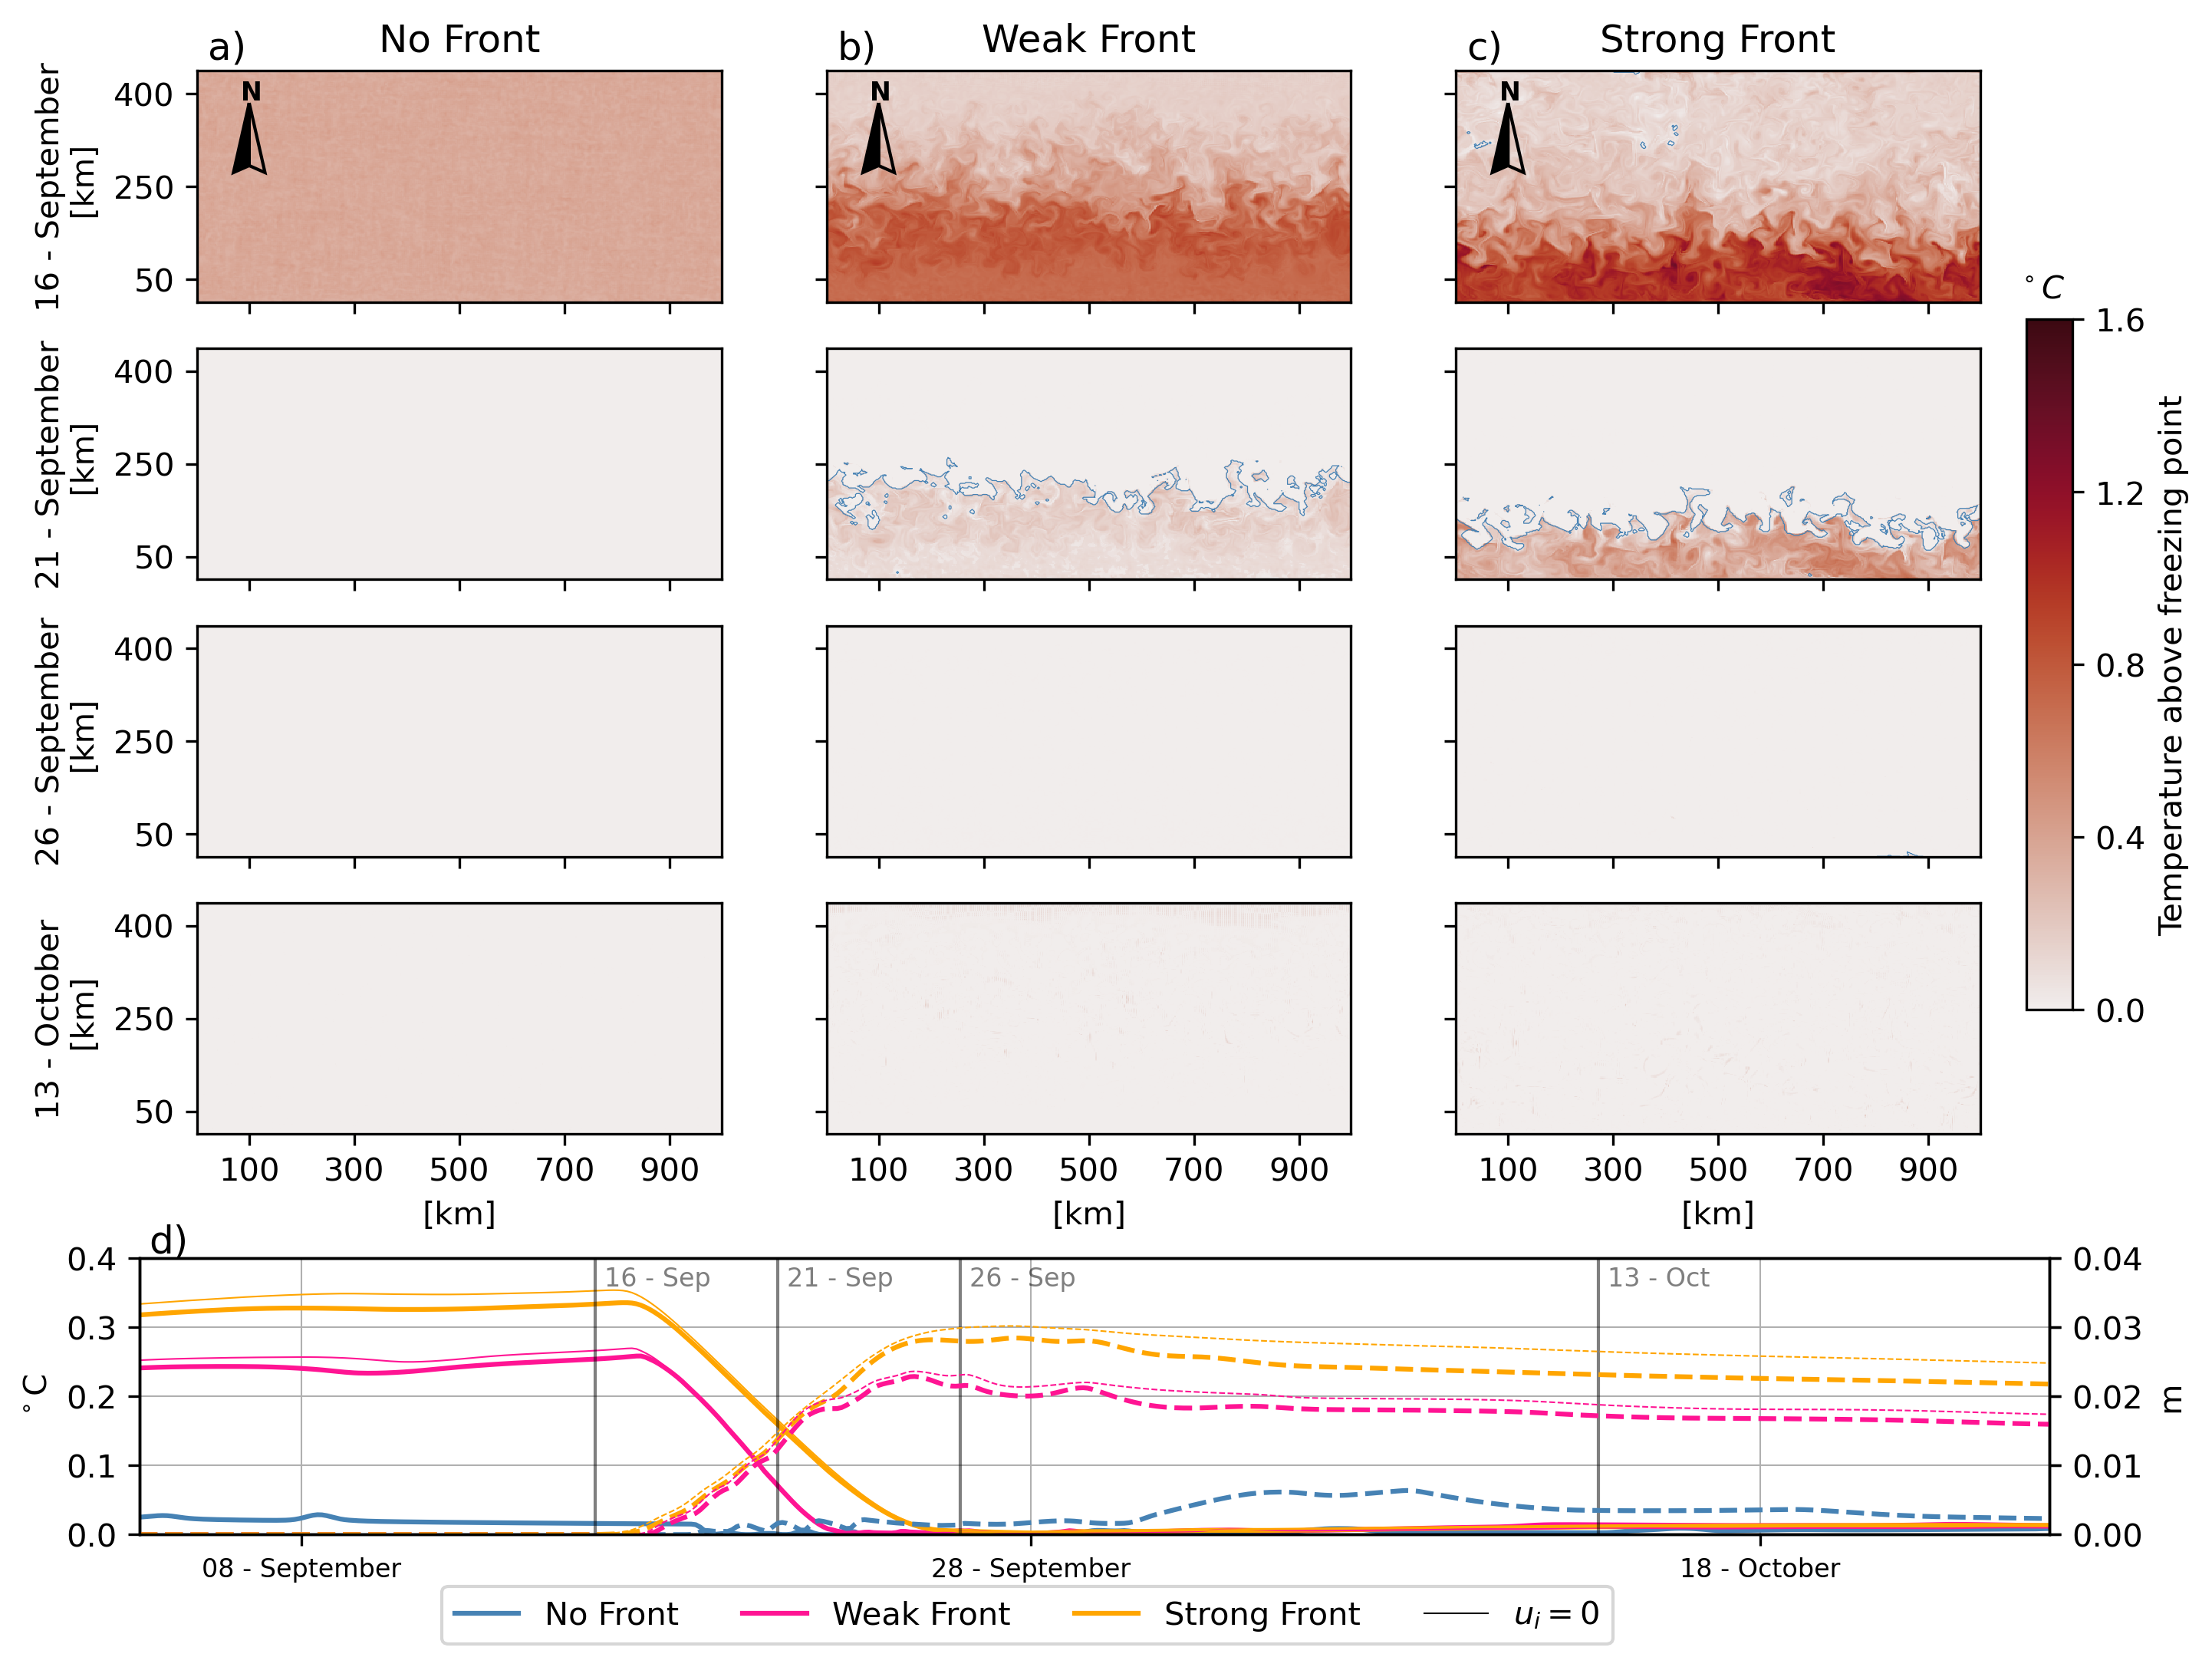

In [30]:

time=freezing_t.time_counter
fig, ax = plt.subplots(4,3,figsize=(10,6),dpi=300,sharey=True,sharex=True)

######################################################################################################
######################################################################################################
######################################################################################################

axs = ax.T[0]

for ii in range(len(time)):
    cbar = (gridT_sel.toce_front_0 - freezing_t.soce_front_0).sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=0,vmax=1.6,cmap=cm.cm.amp,add_colorbar=False,rasterized=True)
    axs[ii].set_ylabel(date_fmt(str(time[ii].values)[5:10])+"\n [km]")
    if ii==0:
        axs[ii].set_title('No Front')
    else:
        axs[ii].set_title('')
        
    change_xticks(axs[ii])
    
######################################################################################################
######################################################################################################
######################################################################################################
    
axs = ax.T[1]

for ii in range(len(time)):
    cbar = (gridT_sel.toce_front_05_noTf - freezing_t.soce_front_05_noTf).sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=0,vmax=1.6,cmap=cm.cm.amp,add_colorbar=False,rasterized=True)
    icemod_sel.icevolu_front_05_noTf.sel(time_counter=time[ii]).plot.contour(x='nav_lon',y='nav_lat',levels=[0],ax=axs[ii],linewidths=0.3,colors=['steelblue'])
    axs[ii].set_title('')
    if ii==0:
        axs[ii].set_title('Weak Front')
    else:
        axs[ii].set_title('')
    change_xticks(axs[ii])

######################################################################################################
######################################################################################################
######################################################################################################
    
axs = ax.T[2]

for ii in range(len(time)):
    cbar = (gridT_sel.toce_front_1_noTf - freezing_t.soce_front_1_noTf).sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=0,vmax=1.6,cmap=cm.cm.amp,add_colorbar=False,rasterized=True)
    icemod_sel.icevolu_front_1_noTf.sel(time_counter=time[ii]).plot.contour(x='nav_lon',y='nav_lat',levels=[0],ax=axs[ii],linewidths=0.3,colors=['steelblue'])
    axs[ii].set_title('')
    if ii==0:
        axs[ii].set_title('Strong Front')
    else:
        axs[ii].set_title('')
    change_xticks(axs[ii])

[a.set_ylabel('') for a in ax[0,1:].ravel()]
[a.set_ylabel('') for a in ax[1:,1:].ravel()]
[a.set_xlabel('') for a in ax[:,:].ravel()]

ax[-1,1].plot(0,0,color='steelblue',label='0% concentration')
ax[-1,1].plot(0,0,color='violet',label='15% concentration')

[a.set_xlabel("[km]") for a in ax[-1,:]]

######################################################################################################
######################################################################################################
######################################################################################################

STD_ax = fig.add_axes([0.1, -0.18, 0.83, 0.2])

color=['steelblue','deeppink','orange']

STD_temp_anomaly_0.plot(x='time_counter', ax=STD_ax, color='steelblue', label='No Front')
STD_temp_anomaly_05.plot(x='time_counter', ax=STD_ax, color='deeppink', label='Weak Front' )
STD_temp_anomaly_1.plot(x='time_counter', ax=STD_ax, color='orange', label='Strong Front' )
STD_temp_anomaly_05_nIVEL.plot(x='time_counter', ax=STD_ax, color='deeppink', linewidth=0.5 )
STD_temp_anomaly_1_nIVEL.plot(x='time_counter', ax=STD_ax, color='orange', linewidth=0.5 )
STD_ax.plot(STD_temp_anomaly_0.time_counter[0],0, linewidth=0.5, color='k',label='$u_i = 0$')

times = icemod_sel.time_counter.values
times_shift = dataset_gridT_3h.time_counter.isel(time_counter=shifted_times).values
at= STD_ax.twinx()

for indx in range(len(times)):
    at.plot([times[indx], times[indx]], [0,0.4], color='k', linewidth=1, alpha=0.5, zorder=0)
    at.text(times_shift[indx], 0.36, date_fmt_y_sm(str(times[indx])[0:10]), fontsize=8, alpha=0.5, ha ='left')

at.set_ylim(0,0.4)
at.set_xlim(STD_temp_anomaly_0.time_counter[0].values,STD_temp_anomaly_0.time_counter[-1].values)
at.set_yticklabels([])

STD_ax.set_ylim(0,0.4)
STD_ax.set_xlim(STD_temp_anomaly_0.time_counter[0].values,STD_temp_anomaly_0.time_counter[-1].values)
STD_ax.grid(linewidth=0.5)
STD_ax.set_title('')
STD_ax.set_xlabel("")
STD_ax.set_ylabel('$^\circ$C')

STD_ax_t = STD_ax.twinx()

color=['steelblue','deeppink','orange']

STD_icevolu_0.plot(x='time_counter', ax=STD_ax_t, color='steelblue', linestyle='--' )
STD_icevolu_05.plot(x='time_counter', ax=STD_ax_t, color='deeppink', linestyle='--' )
STD_icevolu_1.plot(x='time_counter', ax=STD_ax_t, color='orange', linestyle='--' )
STD_icevolu_05_noIVEL.plot(x='time_counter', ax=STD_ax_t, color='deeppink', linestyle='--', linewidth=0.5 )
STD_icevolu_1_noIVEL.plot(x='time_counter', ax=STD_ax_t, color='orange', linestyle='--', linewidth=0.5 )

STD_ax_t.set_ylabel("m")
STD_ax_t.set_ylim(0,0.04)


STD_ax.legend(loc='upper left', bbox_to_anchor=(0.15, -0.13),ncol=4)

######################################################################################################
######################################################################################################
######################################################################################################

cax = fig.add_axes([0.92, 0.2, 0.02, 0.5])
cb=fig.colorbar(cbar, cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cax.text(-0.2,1.65, '$^\circ C$')

cax.set_ylabel("Temperature above freezing point")

plot_north_arrow( ax[0,0], xT=-400, yT=30, scale=15, color='k' )
plot_north_arrow( ax[0,1], xT=-400, yT=30, scale=15, color='k' )
plot_north_arrow( ax[0,2], xT=-400, yT=30, scale=15, color='k' )

plt.draw()

labels = [item.get_text() for item in STD_ax.get_xticklabels()]
updated_labels = [ date_fmt_y(label[0:10]) for label in labels]

STD_ax.set_xticklabels(updated_labels,fontsize=8, ha ='center')

ax[0,0].text(0.02, 1.05, "a)", fontsize=12, transform=ax[0,0].transAxes)
ax[0,1].text(0.02, 1.05, "b)", fontsize=12, transform=ax[0,1].transAxes)
ax[0,2].text(0.02, 1.05, "c)", fontsize=12, transform=ax[0,2].transAxes)
STD_ax.text(0.005, 1.02, "d)", fontsize=12, transform=STD_ax.transAxes)

plt.savefig('./figures/Fig_2_freezing_point_snaps_exps.pdf',dpi=300,bbox_inches='tight')

## Plot the ice thickness.

/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xlabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:405: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(ylabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(xlabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:405: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(ylabels)
/home1/datahome/jmartine/github/Ice_formation/Figures/utils.py:404: UserWarning: set_tic

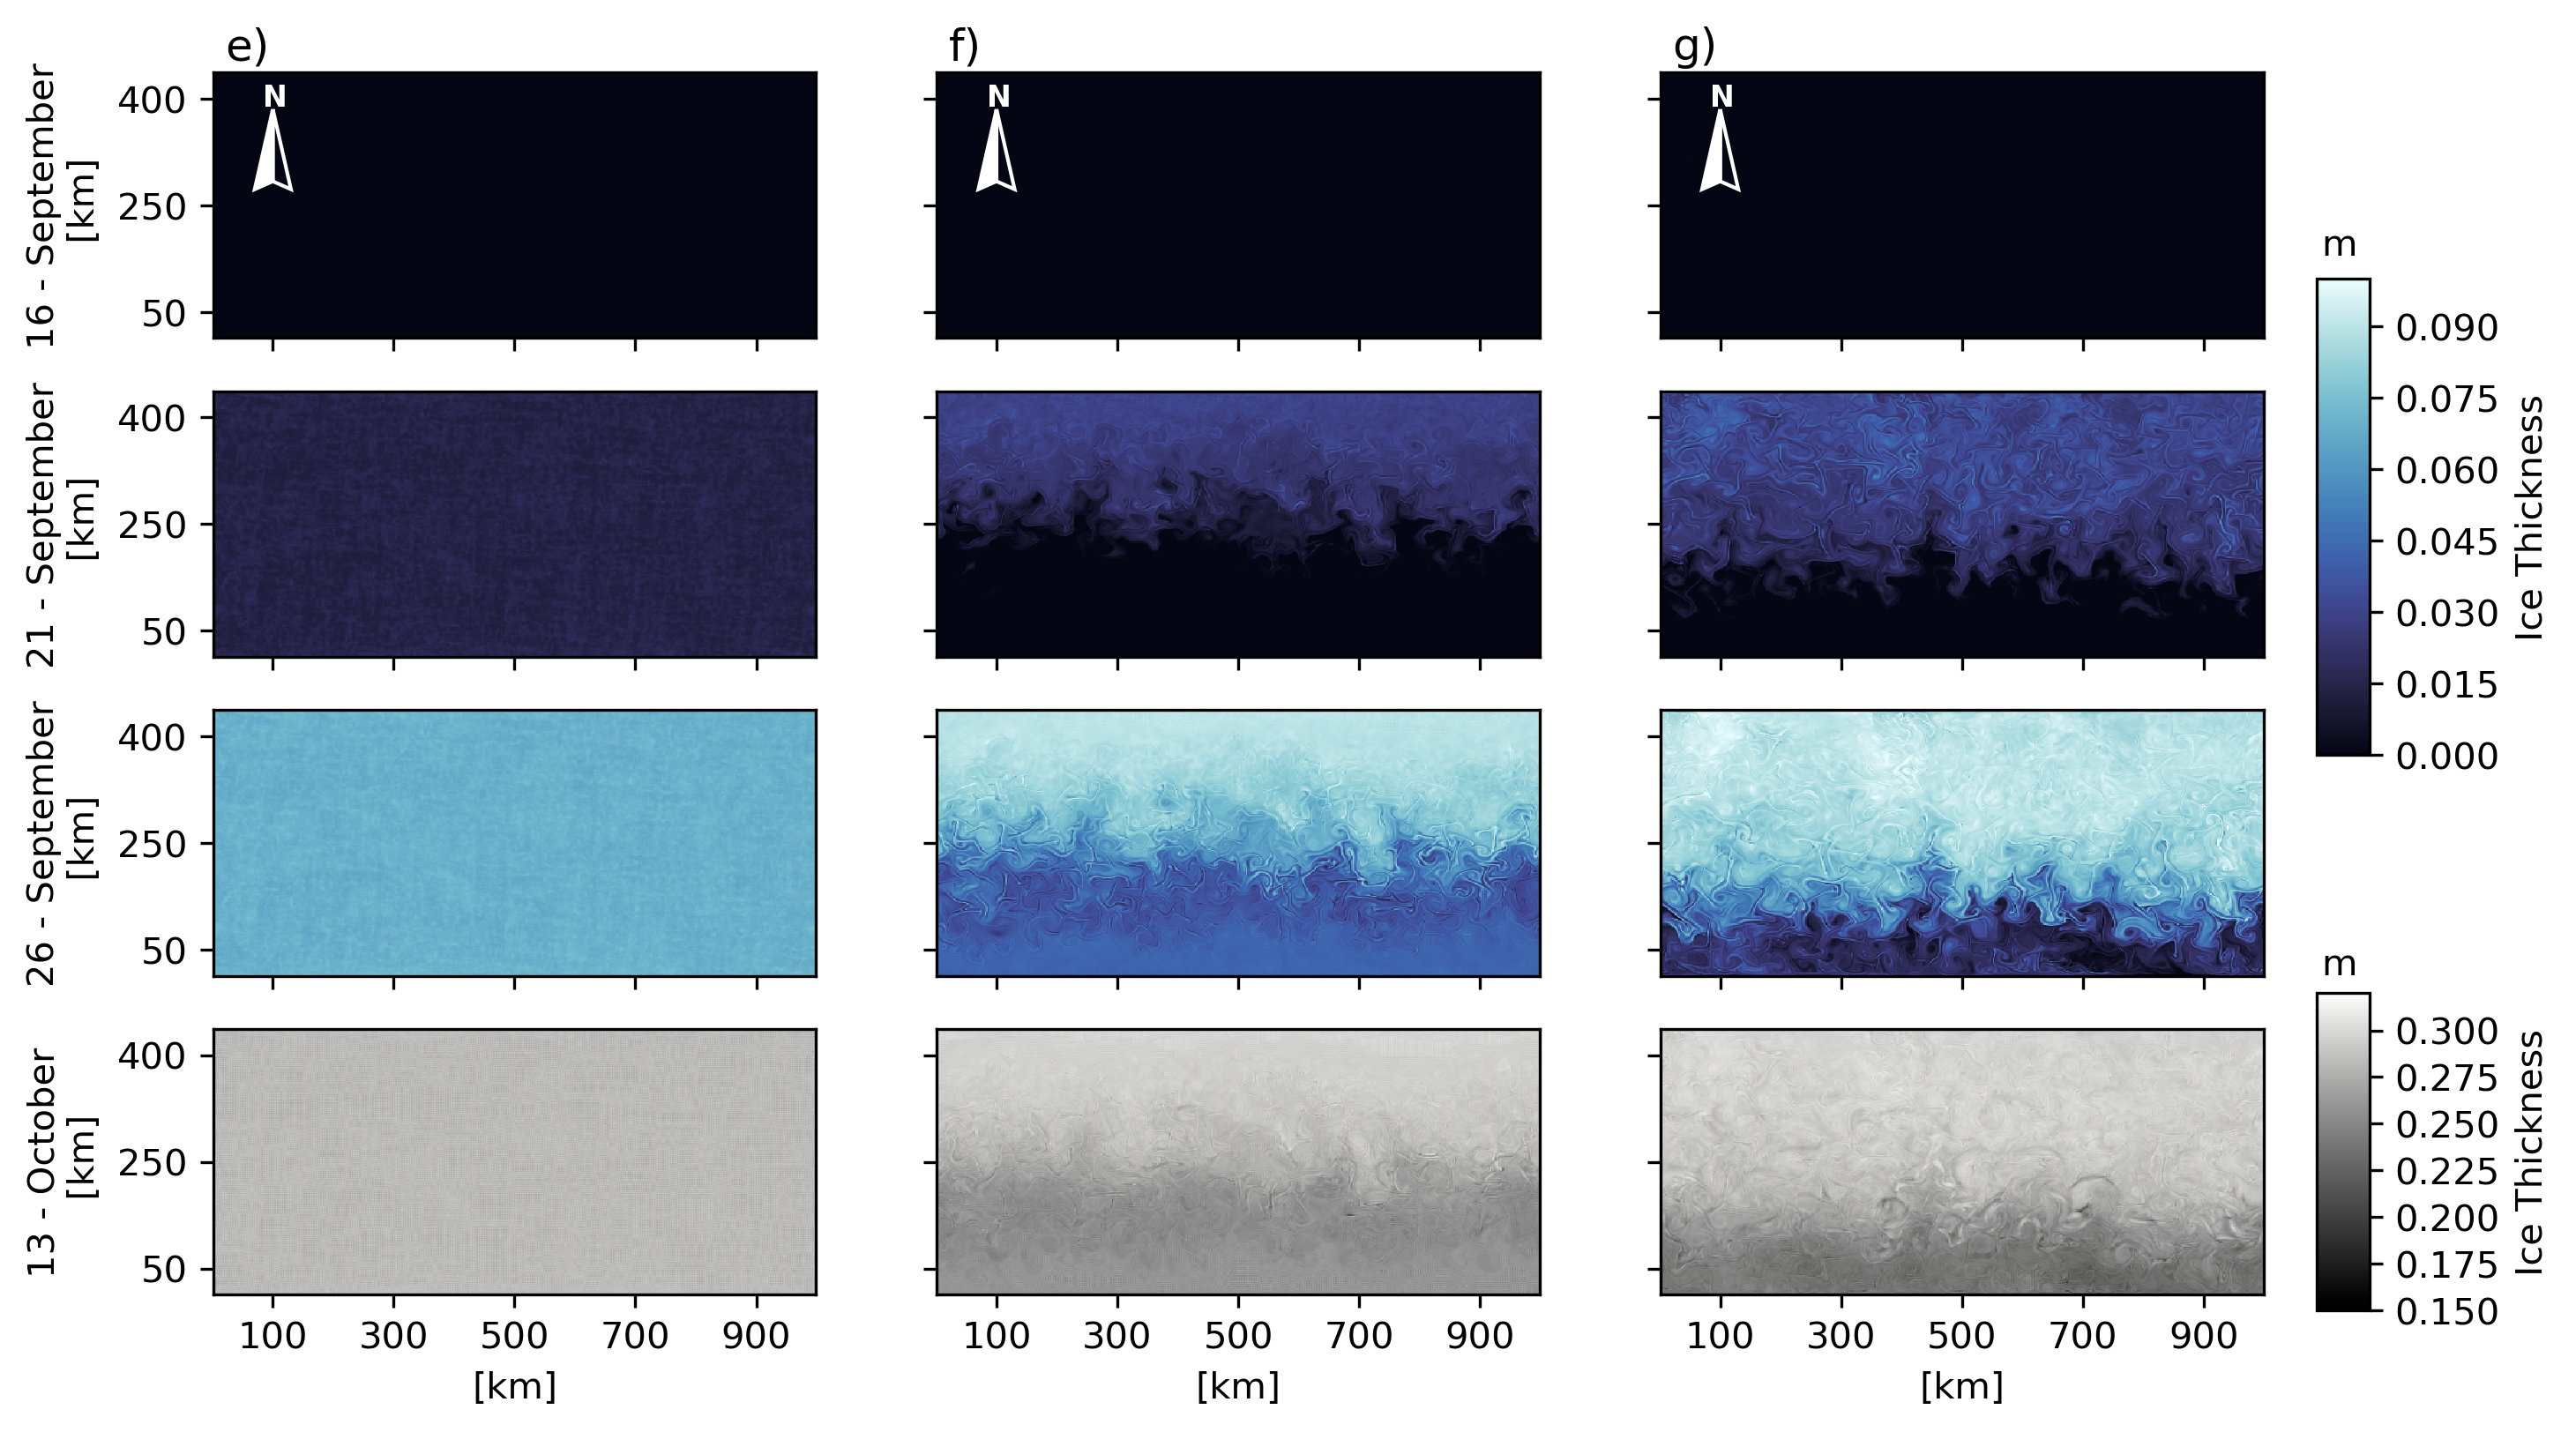

In [31]:
time=freezing_t.time_counter
fig, ax = plt.subplots(4,3,figsize=(10,6),dpi=300,sharey=True,sharex=True)

######################################################################################################
######################################################################################################
######################################################################################################

axs = ax.T[0]

for ii in range(len(time)):

    if ii < 3:
        vmin=0
        vmax=0.1
        cmap=cm.cm.ice
    else:
        vmin=0.15
        vmax=0.32
        cmap=cm.cm.gray
        
    cbar = icemod_sel.icevolu_front_0.sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False,rasterized=True)
    axs[ii].set_ylabel(date_fmt(str(time[ii].values)[5:10])+"\n [km]")
    axs[ii].set_title('')
        
    change_xticks(axs[ii])
    
######################################################################################################
######################################################################################################
######################################################################################################
    
axs = ax.T[1]

for ii in range(len(time)):
    if ii < 3:
        vmin=0
        vmax=0.1
        cmap=cm.cm.ice
    else:
        vmin=0.15
        vmax=0.32
        cmap=cm.cm.gray
    
    cbar = icemod_sel.icevolu_front_05_noTf.sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False,rasterized=True)
    axs[ii].set_title('')
    change_xticks(axs[ii])
    
######################################################################################################
######################################################################################################
######################################################################################################
    
axs = ax.T[2]

cbar_list = []
for ii in range(len(time)):
    if ii < 3:
        vmin=0
        vmax=0.1
        cmap=cm.cm.ice
    else:
        vmin=0.15
        vmax=0.32
        cmap=cm.cm.gray
    
    cbar = icemod_sel.icevolu_front_1_noTf.sel(time_counter=time[ii]).plot(x='nav_lon',y='nav_lat',ax=axs[ii],vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False,rasterized=True)
    cbar_list.append(cbar)
    axs[ii].set_title('')
    change_xticks(axs[ii])

######################################################################################################
######################################################################################################
######################################################################################################
    
[a.set_ylabel('') for a in ax[0,1:].ravel()]
[a.set_ylabel('') for a in ax[1:,1:].ravel()]
[a.set_xlabel('') for a in ax[:,:].ravel()]

[a.set_xlabel("[km]") for a in ax[-1,:]]

cax = fig.add_axes([0.92, 0.45, 0.02, 0.3])
cb=fig.colorbar(cbar_list[0], cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()

cax.text(0.1,0.105, 'm')
cax.set_ylabel("Ice Thickness")

cax = fig.add_axes([0.92, 0.1, 0.02, 0.2])
cb=fig.colorbar(cbar_list[-1], cax=cax, orientation='vertical')
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()


cax.text(0.1,0.33, 'm')
cax.set_ylabel("Ice Thickness")

plot_north_arrow( ax[0,0], xT=-400, yT=30, scale=15, color='w' )
plot_north_arrow( ax[0,1], xT=-400, yT=30, scale=15, color='w' )
plot_north_arrow( ax[0,2], xT=-400, yT=30, scale=15, color='w' )


ax[0,0].text(0.02, 1.05, "e)", fontsize=12, transform=ax[0,0].transAxes)
ax[0,1].text(0.02, 1.05, "f)", fontsize=12, transform=ax[0,1].transAxes)
ax[0,2].text(0.02, 1.05, "g)", fontsize=12, transform=ax[0,2].transAxes)

plt.savefig('./figures/Fig_2_icethic_point_snaps_exps.pdf',dpi=300,bbox_inches='tight')